In [1]:
!pip install pmdarima

In [2]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# For EDA
import seaborn as sns
import matplotlib.pyplot as plt

# Load specific forecasting tools
from statsmodels.tsa.statespace.sarimax import SARIMAX

# for determining (p,q) orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

# for ETS Plots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import statsmodels.api as sm
import itertools

# for determining ARIMA orders
from pmdarima import auto_arima

from datetime import datetime
from functools import partial

# Configurations
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

In [3]:
train = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/train.csv")
oil = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/oil.csv")
holidays = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/holidays_events.csv")
stores = pd.read_csv("/Users/vaidehiparikh/Downloads/IDMP/IDMP Project/store-sales-time-series-forecasting/stores.csv")   

In [4]:
train['date'] = pd.to_datetime(train['date'], format="%Y-%m-%d")
df = train[['date', 'sales']]

In [5]:
df=df.set_index(df.date)
df.drop('date',axis=1,inplace=True)

In [6]:
#resample it to monthly basis
df = df.resample('M').mean()

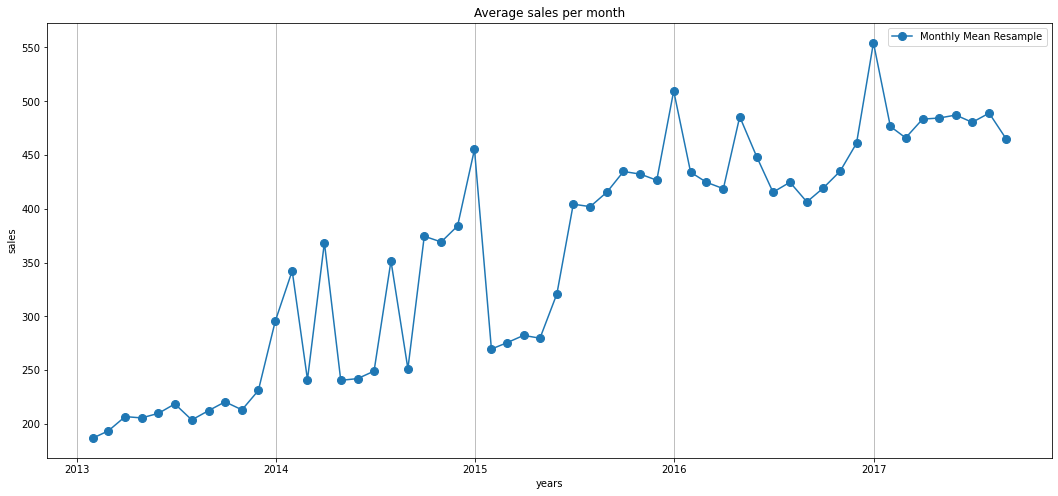

In [7]:
y = df['sales']
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend();

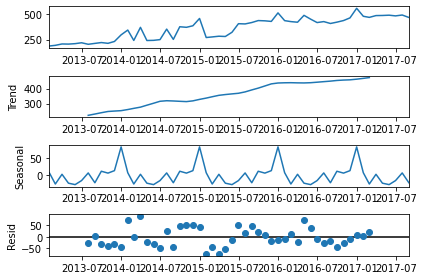

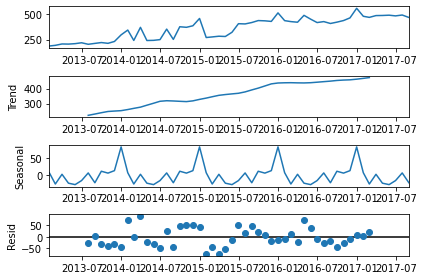

In [8]:
df_decomposed = seasonal_decompose(df,model='additive')
df_decomposed.plot()

In [9]:
dftest = adfuller(df.dropna(), autolag='AIC')

In [10]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -1.574663931940095 
 P-value: 0.4963069089455678 
Critiical Values {'1%': -3.55770911573439, '5%': -2.9167703434435808, '10%': -2.59622219478738}


In [11]:
sales_mean = df.sales.rolling(window=12).mean()
sales_std = df.sales.rolling(window=12).std()

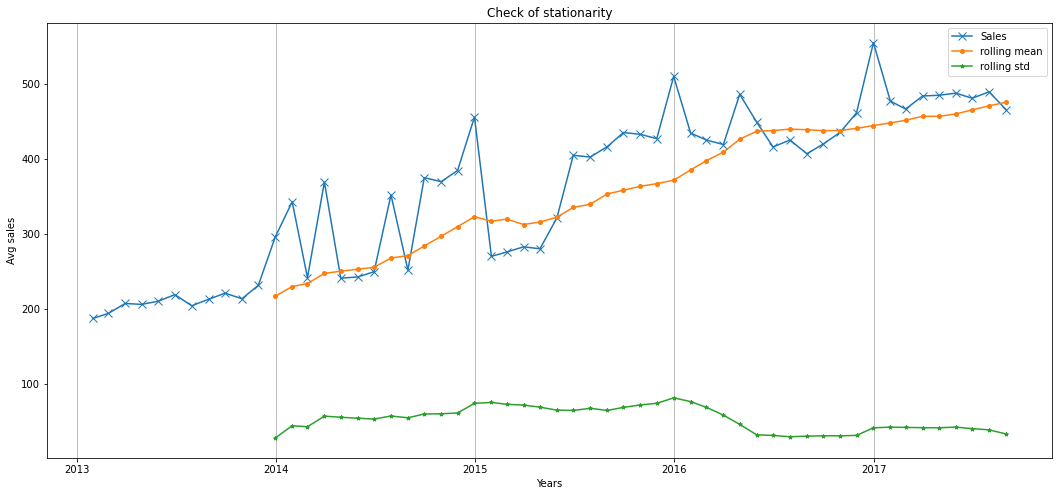

In [12]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df.sales,marker='x', markersize=8, label='Sales')
ax.plot(sales_mean,marker='o', markersize=4, label='rolling mean');
ax.plot(sales_std,marker='*', markersize=4, label='rolling std');
ax.legend()
plt.xlabel('Years')
plt.ylabel('Avg sales')
plt.title('Check of stationarity')
ax.grid(axis='x')

In [13]:
df_lag = df.sales - df.sales.shift(12) #monthly lag

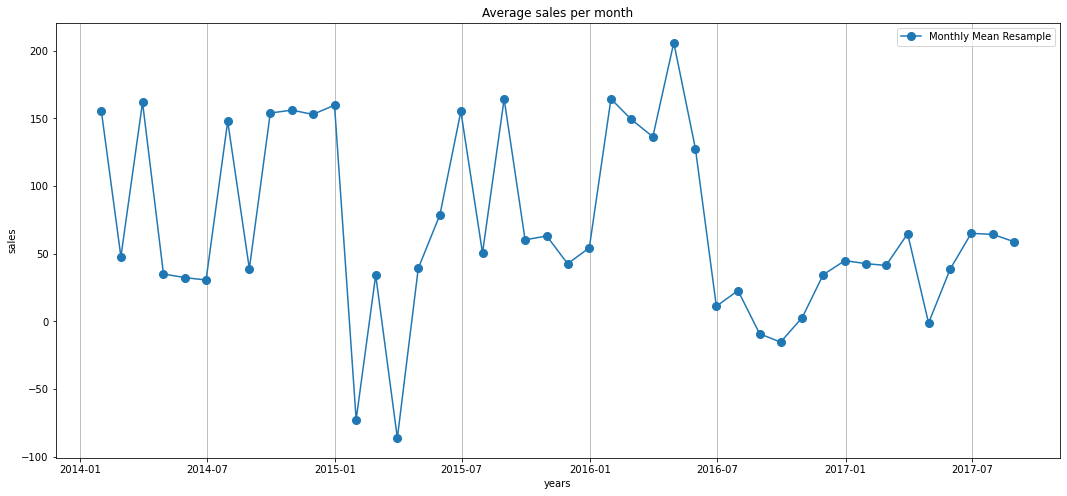

In [14]:
y = df_lag
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('sales')
ax.set_title('Average sales per month')
ax.set_xlabel('years')
ax.grid(axis='x')
ax.legend()

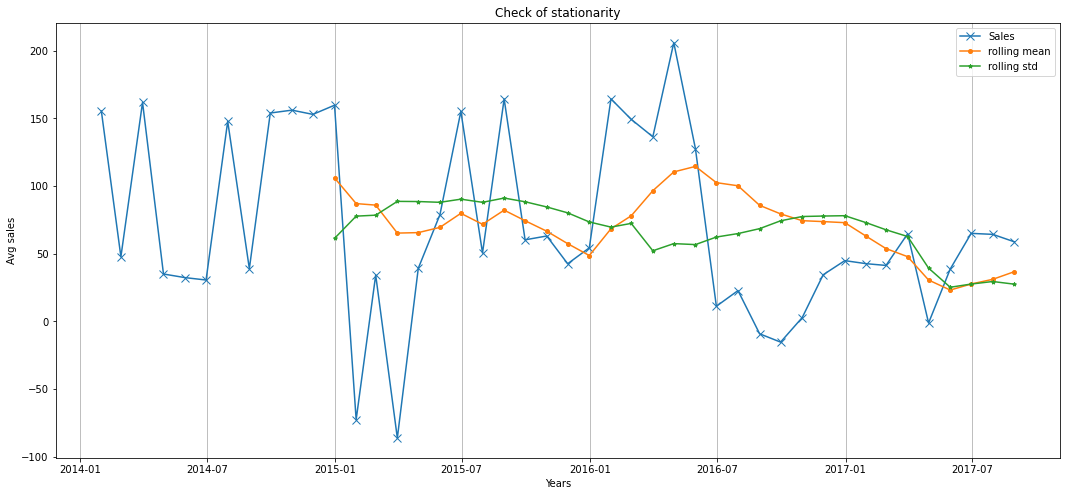

In [15]:
sales_mean = df_lag.rolling(window=12).mean()
sales_std = df_lag.rolling(window=12).std()
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(y,marker='x', markersize=8, label='Sales')
ax.plot(sales_mean,marker='o', markersize=4, label='rolling mean');
ax.plot(sales_std,marker='*', markersize=4, label='rolling std');
ax.legend()
plt.xlabel('Years')
plt.ylabel('Avg sales')
plt.title('Check of stationarity')
ax.grid(axis='x')

In [16]:
dftest = adfuller(df_lag.dropna(), autolag='AIC')

In [17]:
print("test statistic:",dftest[0],"\n P-value:" ,dftest[1],"\nCritiical Values",dftest[4])

test statistic: -3.7531512241898053 
 P-value: 0.0034247012202059173 
Critiical Values {'1%': -3.6055648906249997, '5%': -2.937069375, '10%': -2.606985625}


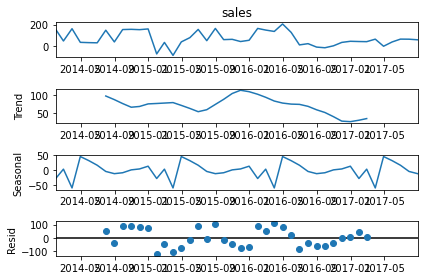

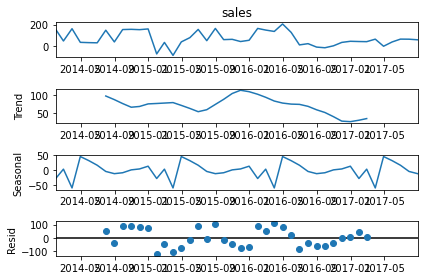

In [18]:
df_decomposed = seasonal_decompose(df_lag.dropna(),model='additive')
df_decomposed.plot()

In [19]:
df_train = df.iloc[:-8]
df_train.shape

(48, 1)

In [20]:
df_test = df.iloc[-8:]
df_test.shape

(8, 1)

In [21]:
es = ExponentialSmoothing(df_train, seasonal_periods=12,trend='add', seasonal='mul').fit()
es_preds = es.forecast(steps=12)
pd.DataFrame(es_preds)

,0
2017-01-31,440.95
2017-02-28,414.49
2017-03-31,457.47
2017-04-30,444.92
2017-05-31,441.84
2017-06-30,456.11
2017-07-31,486.34
2017-08-31,457.60
2017-09-30,506.90
2017-10-31,510.08


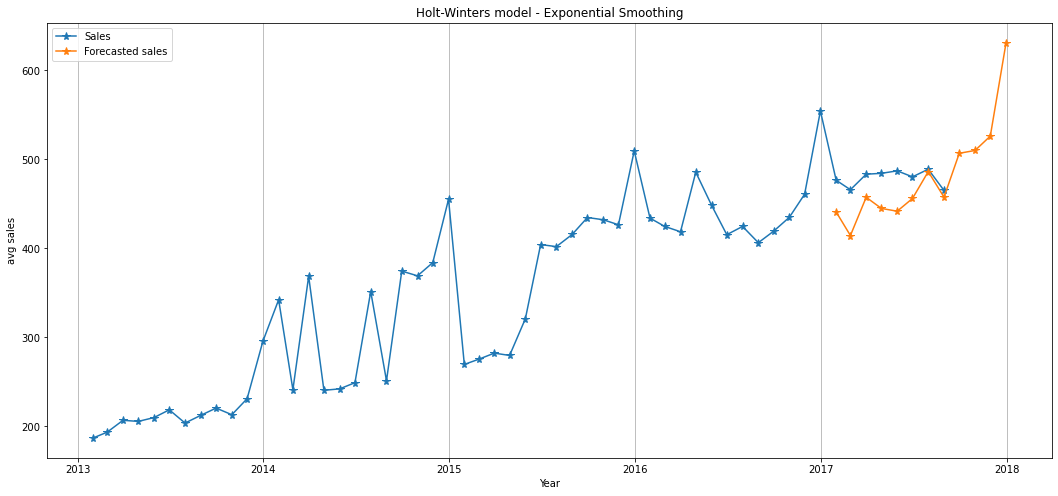

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df,marker='*', markersize=8, label='Sales')
ax.plot(es_preds,marker='*', markersize=8, label='Forecasted sales');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Holt-Winters model - Exponential Smoothing' )
ax.grid(axis='x')
ax.legend()
plt.show()

In [23]:
residuals = np.abs(es_preds[0] - df_test['sales'])

In [24]:
mape = (residuals/df_test['sales']).mean()*100

In [25]:
print(f'The mape value of Holt-Winters model is {mape}')

The mape value of Holt-Winters model is 7.914854534384522


In [26]:
es_preds=es.forecast(steps=24)

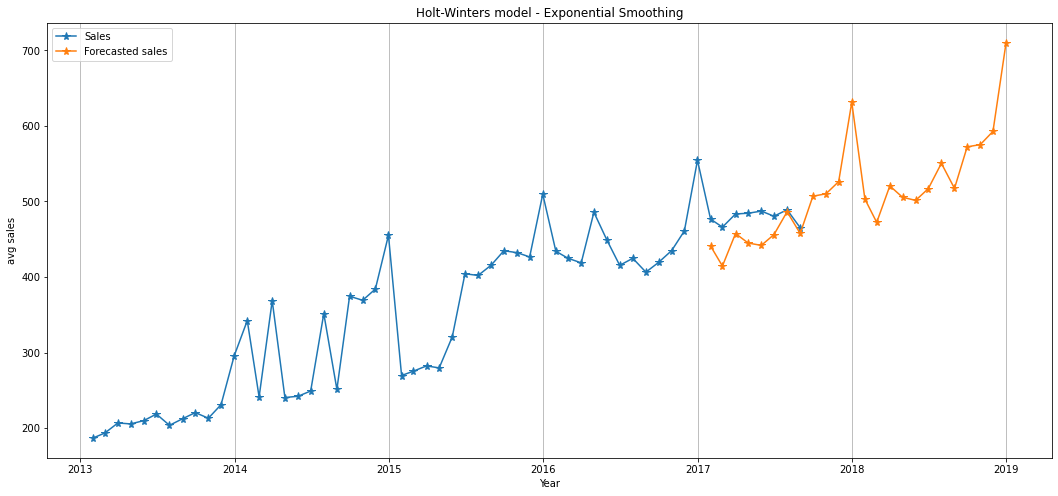

In [27]:
fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(df,marker='*', markersize=8, label='Sales')
ax.plot(es_preds,marker='*', markersize=8, label='Forecasted sales');
plt.xlabel('Year')
plt.ylabel('avg sales')
plt.title('Holt-Winters model - Exponential Smoothing' )
ax.grid(axis='x')
ax.legend()
plt.show()

In [28]:
grocery1 = train[train['family'] == 'GROCERY I']
grocery1

,id,date,store_nbr,family,sales,onpromotion
12,12,2013-01-01,1,GROCERY I,0.00,0
45,45,2013-01-01,10,GROCERY I,0.00,0
78,78,2013-01-01,11,GROCERY I,0.00,0
111,111,2013-01-01,12,GROCERY I,0.00,0
144,144,2013-01-01,13,GROCERY I,0.00,0
...,...,...,...,...,...,...
3000735,3000735,2017-08-15,54,GROCERY I,4235.00,44
3000768,3000768,2017-08-15,6,GROCERY I,4334.00,33
3000801,3000801,2017-08-15,7,GROCERY I,3678.00,34
3000834,3000834,2017-08-15,8,GROCERY I,4035.00,34


In [29]:
# Dropping the rest of the columns
cols = ['id','store_nbr','family','onpromotion']
grocery1.drop(cols,axis =1,inplace=True)

In [30]:
# Viewing the data
grocery1

,date,sales
12,2013-01-01,0.00
45,2013-01-01,0.00
78,2013-01-01,0.00
111,2013-01-01,0.00
144,2013-01-01,0.00
...,...,...
3000735,2017-08-15,4235.00
3000768,2017-08-15,4334.00
3000801,2017-08-15,3678.00
3000834,2017-08-15,4035.00


In [31]:
# Converting to date format
to_datetime_fmt = partial(pd.to_datetime)

#performing a group by on date and taking the sum of sales
grocery1 = grocery1.groupby('date')['sales'].sum()
grocery1=grocery1.reset_index()

In [32]:
#converting object format to date format
grocery1['date'] = grocery1['date'].apply(to_datetime_fmt)

#Setting date column as the index
grocery1.set_index('date',inplace=True)
grocery1

,sales
date,
2013-01-01,700.00
2013-01-02,202020.00
2013-01-03,144878.00
2013-01-04,135754.00
2013-01-05,188356.00
...,...
2017-08-11,238221.92
2017-08-12,238627.63
2017-08-13,258442.45


In [33]:
# Re-sampling the data and taking mean
y = grocery1['sales'].resample('MS').mean()

<AxesSubplot:xlabel='date'>

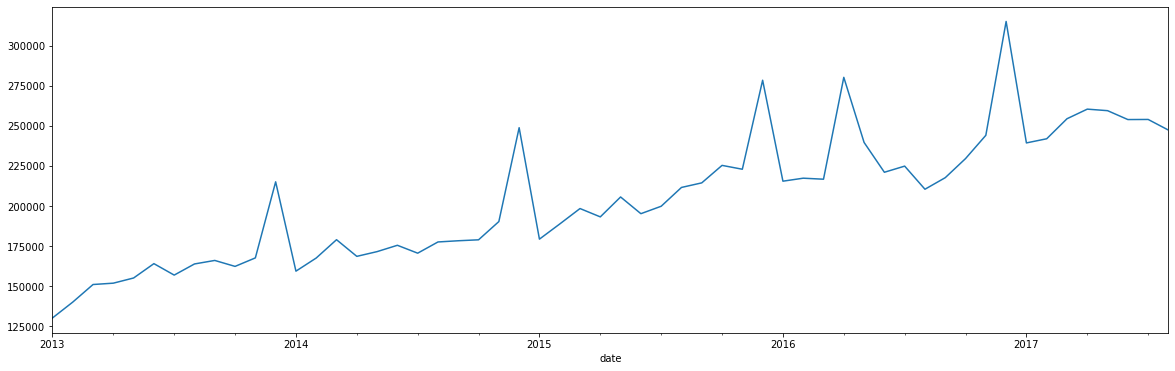

In [34]:
# viewing the sales trend for each date
y.plot(figsize=(20,6))

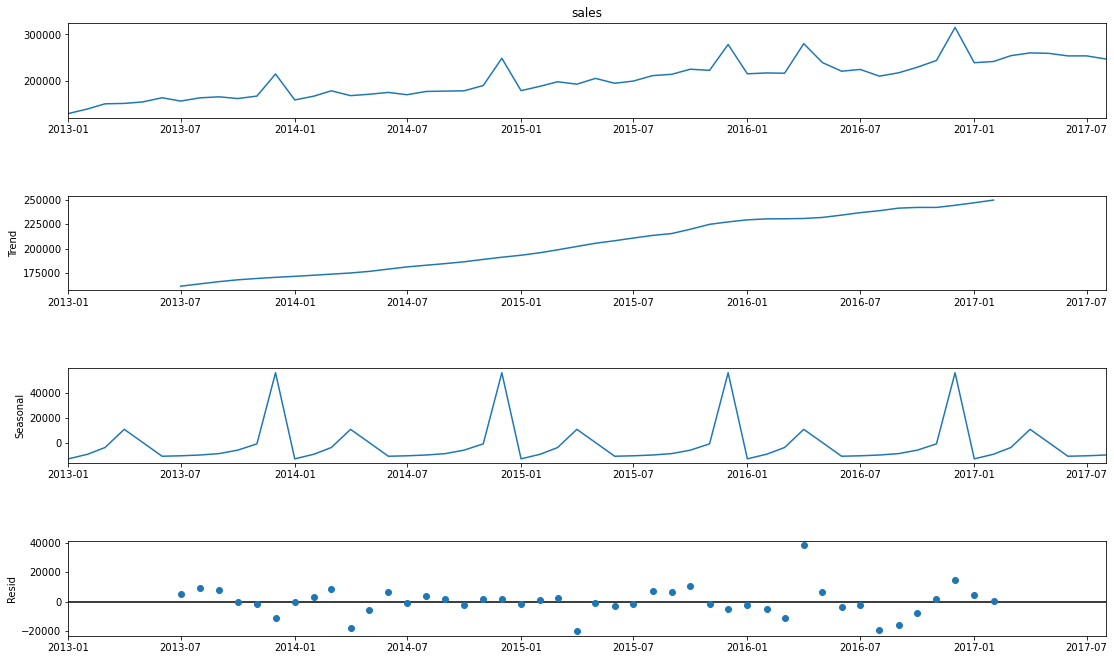

In [35]:
from pylab import rcParams


decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()

fig.set_size_inches(18.5, 10.5)
plt.show()

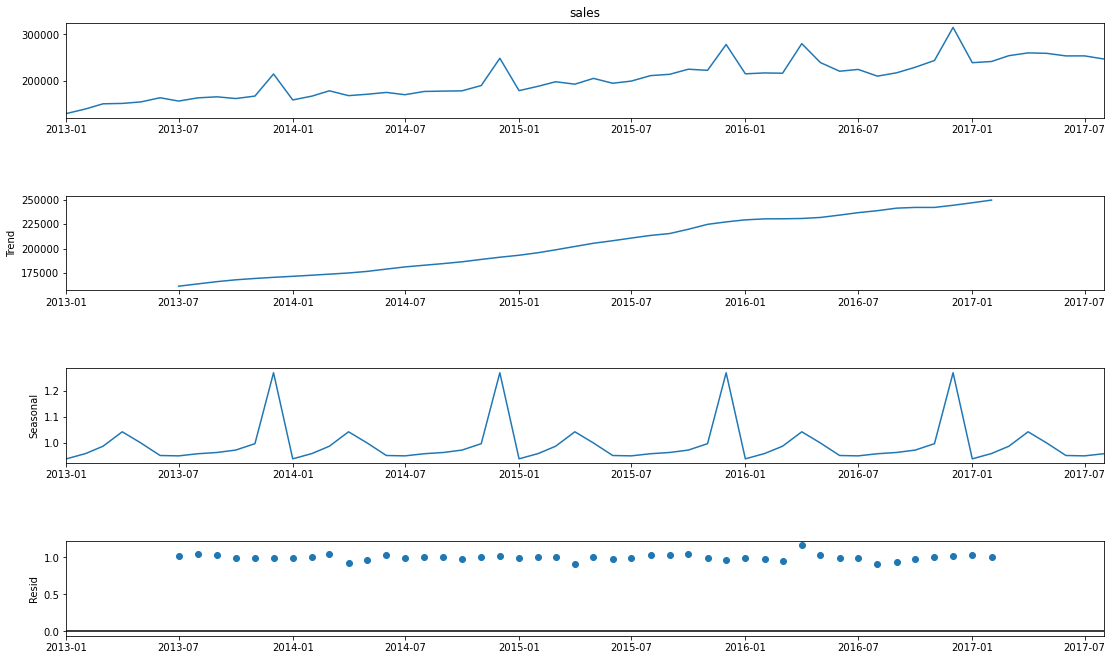

In [36]:
decomposition = sm.tsa.seasonal_decompose(y,model='multiplicative')
fig = decomposition.plot()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [37]:
# for testing purpose using pdq =(1,10), seasonal_order= (1,1,0,12)
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12), #monthly basis
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   56
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -334.388
Date:                            Fri, 13 May 2022   AIC                            674.775
Time:                                    12:58:20   BIC                            678.979
Sample:                                01-01-2013   HQIC                           676.120
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4085      0.144     -2.842      0.004      -0.690      -0.127
ar.S.L12      -0.7029      0.380   

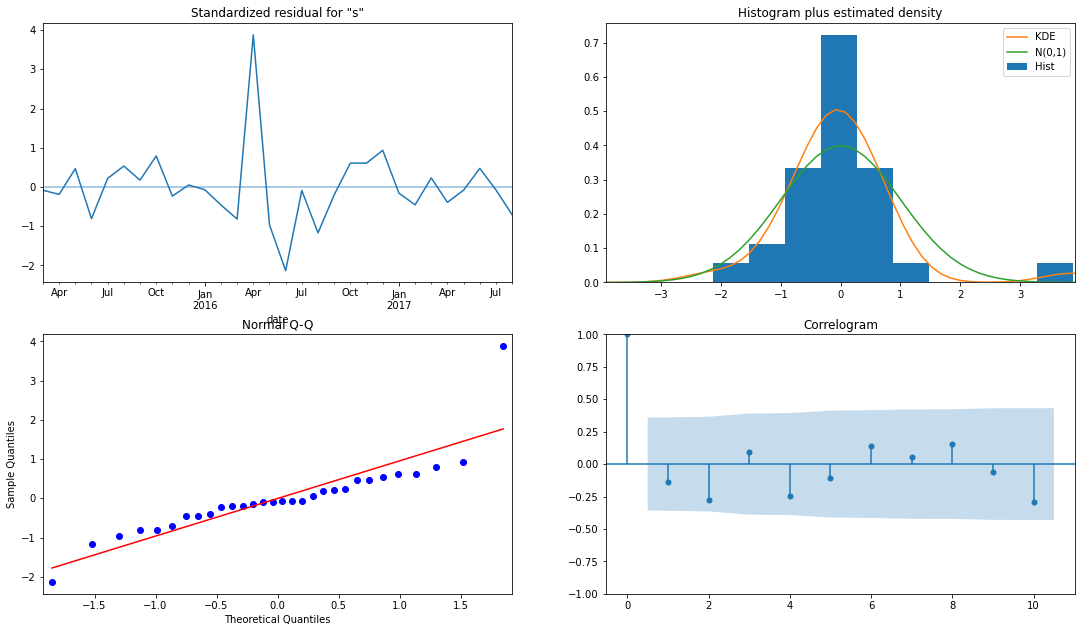

In [38]:
#Plotting results
fig=results.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [39]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#viewing the predicted value interval
pred_ci

,lower sales,upper sales
date,,
2017-01-01,207855.32,276310.85
2017-02-01,215662.85,284118.38
2017-03-01,216189.60,284645.13
2017-04-01,233036.67,301492.20
2017-05-01,226644.48,295100.01
2017-06-01,211418.59,279874.12
2017-07-01,221115.48,289571.01
2017-08-01,225505.54,293961.07


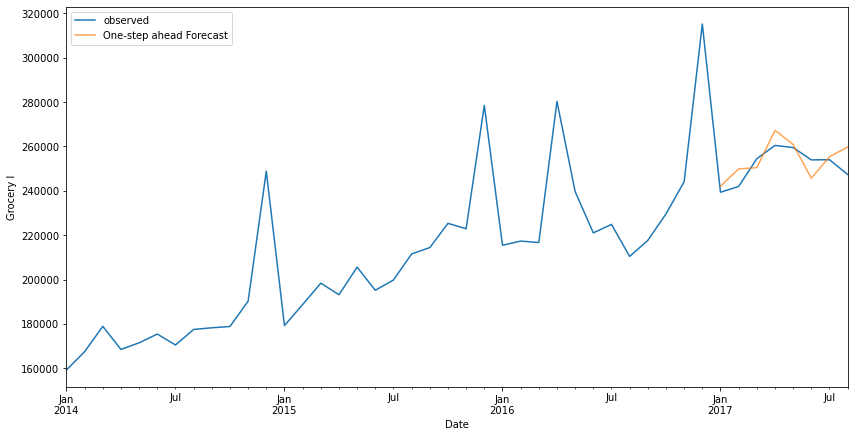

In [40]:
# Ploting the validation Results
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Grocery I')
plt.legend()
plt.show()

In [41]:
# Calculating MAPE for the validation data
y_forecasted = pred.predicted_mean
Y_actual = y['2017-01-01':]
mape = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
print('The MAPE of our forecasts is '+str(round(mape, 2)))

The MAPE of our forecasts is 2.25


In [42]:
# Peforming future forecast
pred_uc = results.get_forecast(steps=25)
pred_ci = pred_uc.conf_int()

pred_ci

,lower sales,upper sales
2017-09-01,221608.62,290064.15
2017-10-01,225509.14,305044.17
2017-11-01,221135.43,316114.31
2017-12-01,275455.75,381538.16
2018-01-01,203339.65,320257.15
2018-02-01,200566.50,327097.11
2018-03-01,199331.06,334908.19
2018-04-01,241583.10,385595.91
2018-05-01,208743.52,360741.46
2018-06-01,190221.14,349798.56


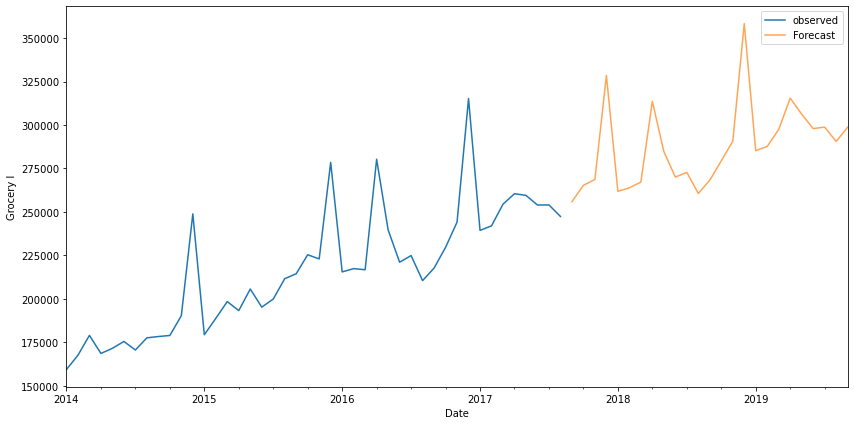

In [43]:
# visualizing future forecast
ax = y['2014':].plot(label='observed')
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Grocery I')
plt.legend()
plt.show()

In [44]:
# Filtering data based on store_nbr
store44 = train[train['store_nbr'] == 44]
store44

,id,date,store_nbr,family,sales,onpromotion
1254,1254,2013-01-01,44,AUTOMOTIVE,0.00,0
1255,1255,2013-01-01,44,BABY CARE,0.00,0
1256,1256,2013-01-01,44,BEAUTY,0.00,0
1257,1257,2013-01-01,44,BEVERAGES,0.00,0
1258,1258,2013-01-01,44,BOOKS,0.00,0
...,...,...,...,...,...,...
3000388,3000388,2017-08-15,44,POULTRY,909.19,0
3000389,3000389,2017-08-15,44,PREPARED FOODS,329.52,0
3000390,3000390,2017-08-15,44,PRODUCE,7239.62,10
3000391,3000391,2017-08-15,44,SCHOOL AND OFFICE SUPPLIES,345.00,12


In [45]:
# Dropping the rest of the columns
cols = ['id','store_nbr','family','onpromotion']
store44.drop(cols,axis =1,inplace=True)

In [46]:
# Converting to date format
to_datetime_fmt = partial(pd.to_datetime)

# performing a group by on date and taking the sum of sales
store44 = store44.groupby('date')['sales'].sum()
store44=store44.reset_index()

In [47]:
# Converting object format to date format
store44['date'] = store44['date'].apply(to_datetime_fmt)

# Setting date column as the index
store44.set_index('date',inplace=True)

In [48]:
# Re-sampling the data and taking the mean value
y = store44['sales'].resample('MS').mean()

<AxesSubplot:xlabel='date'>

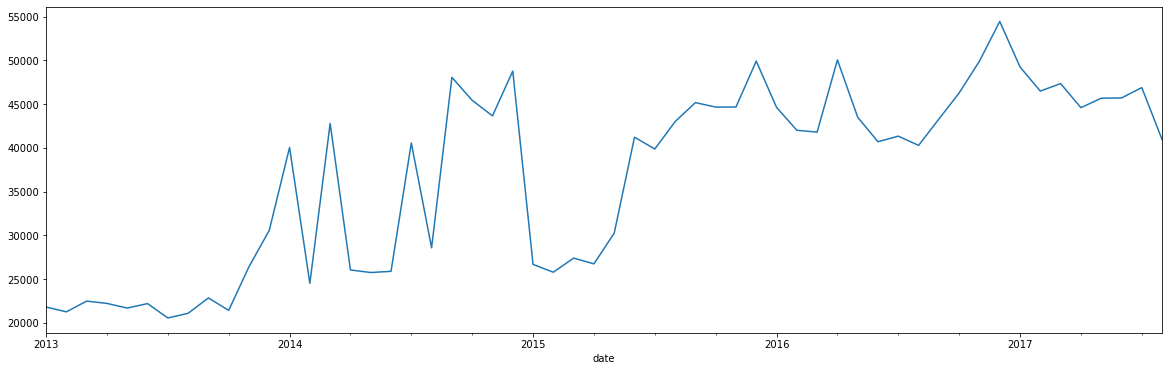

In [49]:
# viewing the sales trend for each date
y.plot(figsize=(20,6))

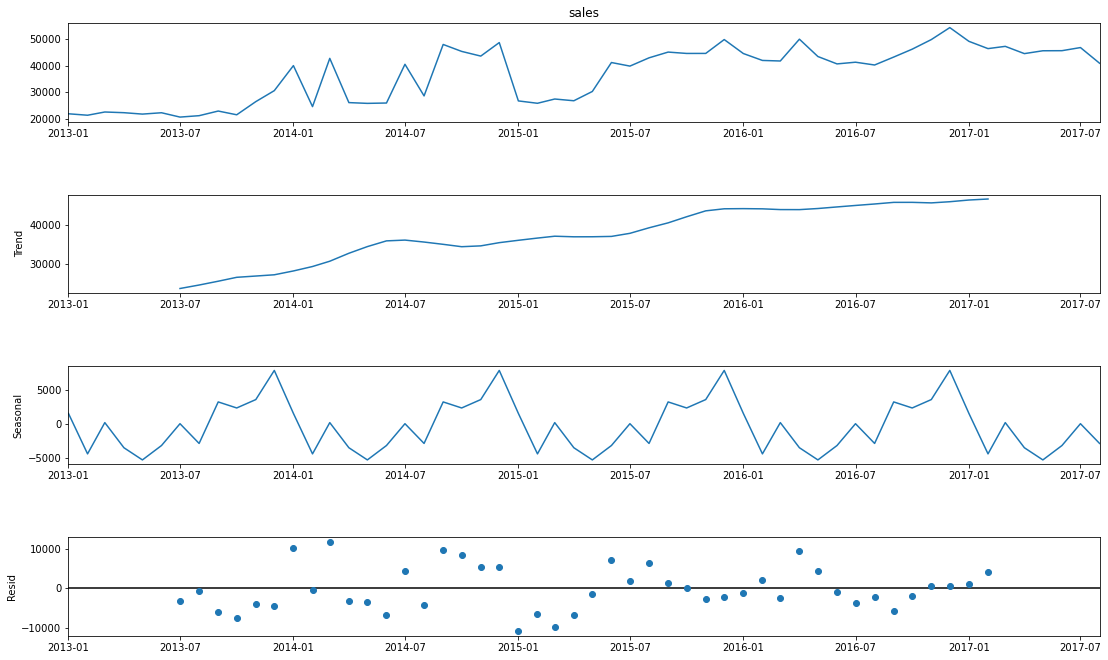

In [50]:
decomposition = sm.tsa.seasonal_decompose(y,model='additive')
fig = decomposition.plot()

fig.set_size_inches(18.5, 10.5)
plt.show()

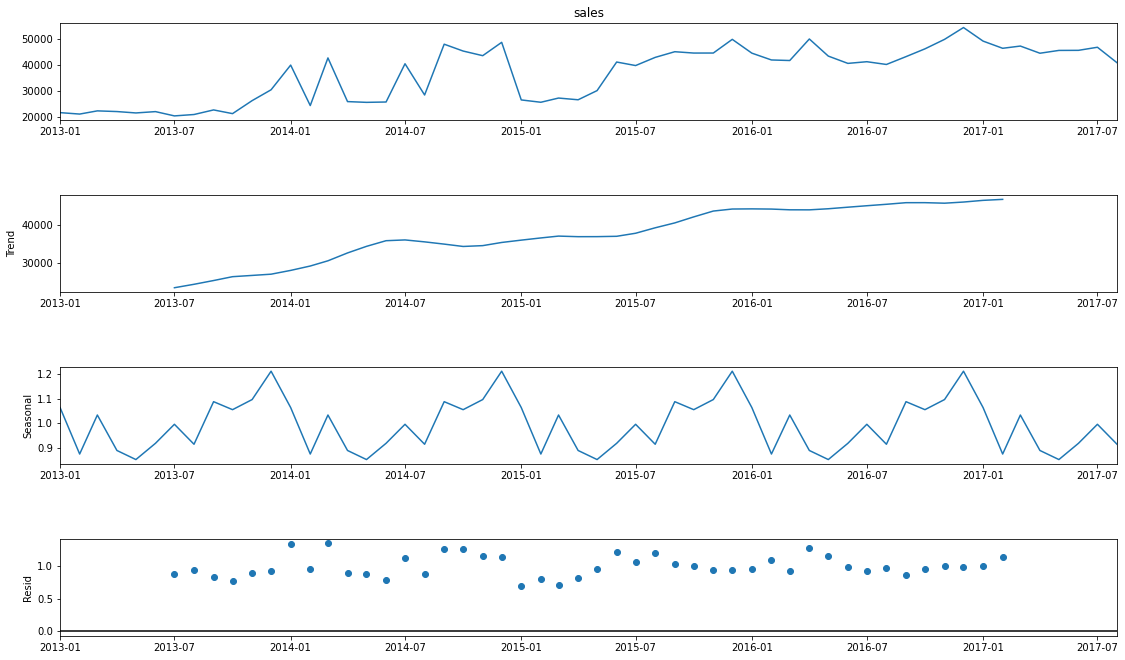

In [51]:
decomposition = sm.tsa.seasonal_decompose(y,model='multiplicative')
fig = decomposition.plot()

fig.set_size_inches(18.5, 10.5)
plt.show()

In [52]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12), #monthly basis
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                              sales   No. Observations:                   56
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -303.187
Date:                            Fri, 13 May 2022   AIC                            612.374
Time:                                    12:58:22   BIC                            616.578
Sample:                                01-01-2013   HQIC                           613.719
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4776      0.165     -2.897      0.004      -0.801      -0.155
ar.S.L12      -0.4778      0.119   

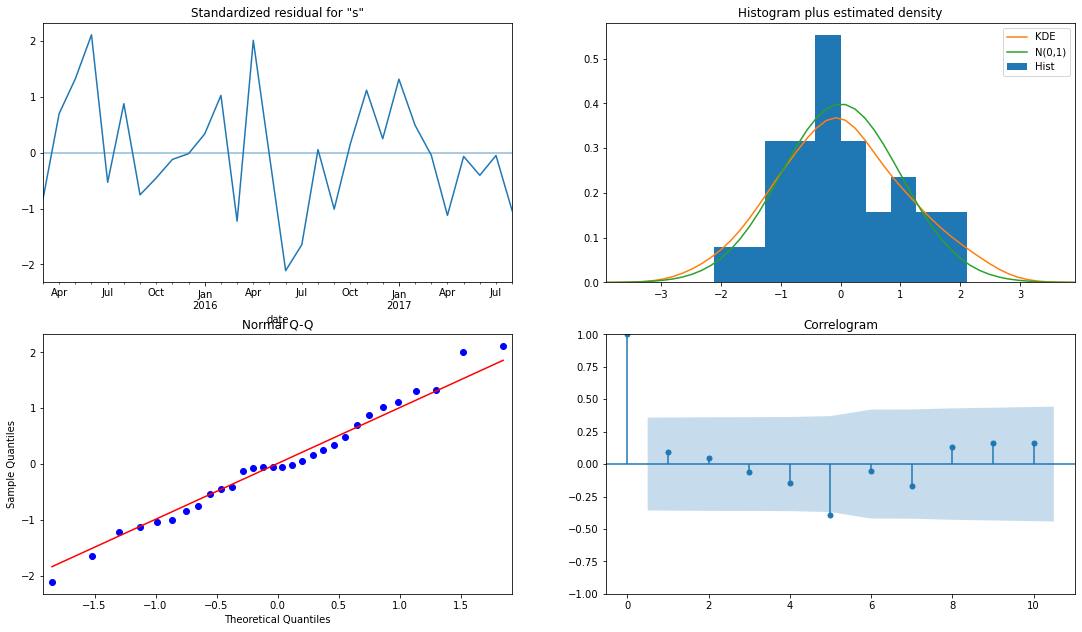

In [53]:
#Plotting results
fig=results.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [54]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

# viewing the predicted value interval
pred_ci

,lower sales,upper sales
date,,
2017-01-01,29829.47,53063.31
2017-02-01,31965.34,55199.18
2017-03-01,35999.47,59233.31
2017-04-01,39637.91,62871.75
2017-05-01,34458.86,57692.69
2017-06-01,36490.99,59724.83
2017-07-01,35573.48,58807.32
2017-08-01,35509.39,58743.23


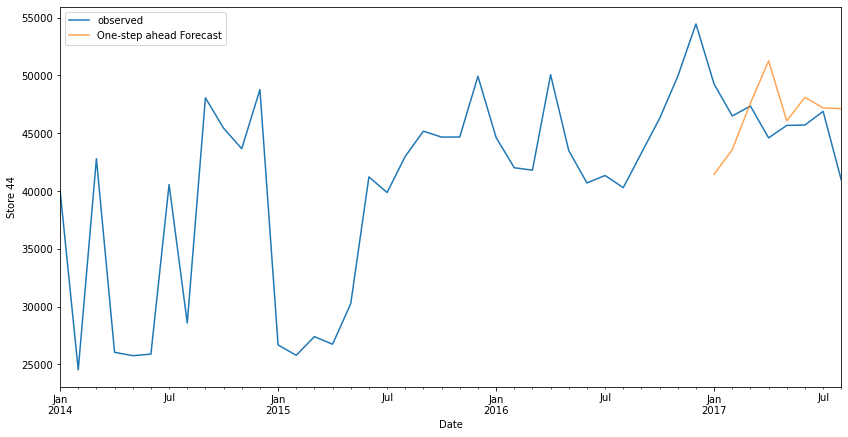

In [55]:
# Plotting validation forecast values
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Store 44')
plt.legend()
plt.show()

In [56]:
# Calculating the MAPE for the validation forecast
y_forecasted = pred.predicted_mean
Y_actual = y['2017-01-01':]
mape = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
print('The MAPE of our forecasts is '+str(round(mape, 2)))

The MAPE of our forecasts is 7.42


In [57]:
# Creating transformation of sales data

# Calculating the log of the sales data
store44['sales_log'] = np.log(store44['sales'])

# Calculating the square root of the sales data
store44['sales_sqrt'] = np.sqrt(store44['sales'])

# Calculating the cubed root of the sales data
store44['sales_cbrt'] = np.cbrt(store44['sales'])

,sales_log
date,
2013-01-01,10.44
2013-01-02,10.31
2013-01-03,9.93
2013-01-04,10.03
2013-01-05,10.35
...,...
2017-08-11,10.68
2017-08-12,10.63
2017-08-13,10.73


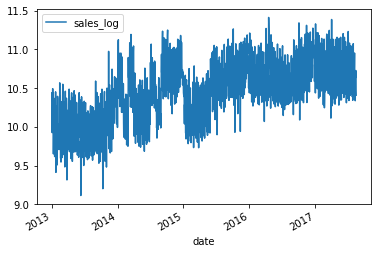

In [58]:
# Viewing log transformed sales data
y = store44['sales_log']

y=pd.DataFrame(y)
y.replace([np.inf, -np.inf], np.nan, inplace=True)
y.replace(np.nan, y.sales_log.mean(), inplace=True)

y.plot()
y

In [59]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12), #monthly basis
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                          sales_log   No. Observations:                 1684
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -831.424
Date:                            Fri, 13 May 2022   AIC                           1668.848
Time:                                    12:58:23   BIC                           1685.088
Sample:                                         0   HQIC                          1674.868
                                           - 1684                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0089      0.028     -0.320      0.749      -0.063       0.046
ar.S.L12      -0.6406      0.022   

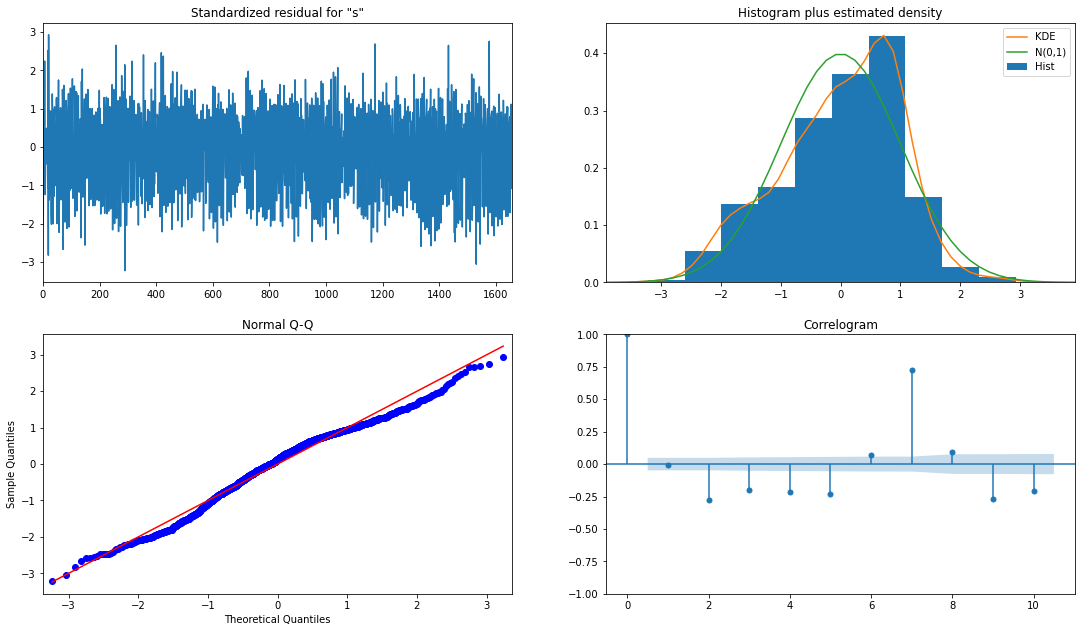

In [60]:
# Plotting results
fig=results.plot_diagnostics()
fig.set_size_inches(18.5, 10.5)
plt.show()

In [61]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), dynamic=False)
pred_ci = pred.conf_int()

#viewing the predicted value interval
pred_ci

,lower sales_log,upper sales_log
date,,
2017-01-01,9.85,11.42
2017-01-02,9.49,11.05
2017-01-03,10.76,12.33
2017-01-04,10.17,11.74
2017-01-05,10.30,11.87
...,...,...
2017-08-11,9.45,11.01
2017-08-12,9.88,11.44
2017-08-13,9.69,11.26


In [72]:
y_forecasted = pred.predicted_mean
Y_actual = y['2017-01-01':]
x = Y_actual - y_forecasted
mape = np.mean(np.abs((Y_actual - y_forecasted)/Y_actual))*100
print('The MAPE of our forecasts is '+str(round(mape, 2)))

date
2017-01-01   10.64
2017-01-02   10.27
2017-01-03   11.55
2017-01-04   10.95
2017-01-05   11.09
              ... 
2017-08-11   10.23
2017-08-12   10.66
2017-08-13   10.48
2017-08-14   10.91
2017-08-15   10.53
Name: predicted_mean, Length: 227, dtype: float64


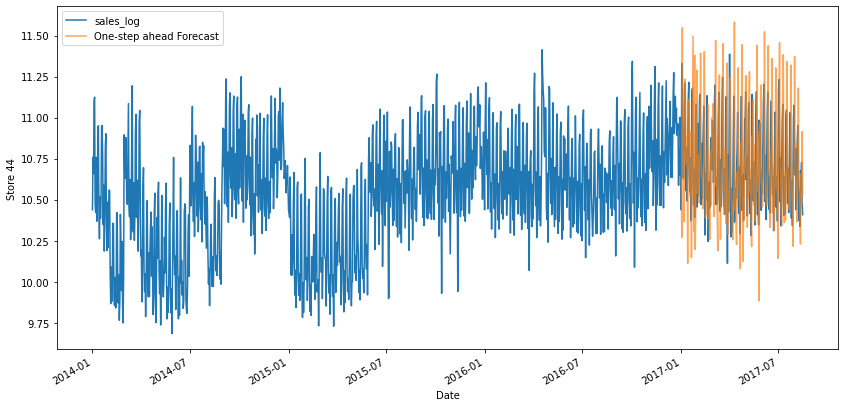

In [64]:
# Ploting validation forecast
ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.set_xlabel('Date')
ax.set_ylabel('Store 44')
plt.legend()
plt.show()